In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import pickle
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import tensorflow_datasets as tfds

In [ ]:
# path='/content/drive/MyDrive/Indiana Coursework/DLS/DLS Project/paris_mobility.txt'

In [3]:
ls '/content/drive/MyDrive/DLS_project/datasets'

chicken_pox.csv  paris_mobility.txt  windmill_medium.csv
energy_data.csv  windmill.csv


In [4]:
path='/content/drive/MyDrive/DLS_project/datasets/paris_mobility.txt'

In [5]:
data =  pd.read_csv(path,header=None)

In [6]:
data = np.array(data)
data.shape

(3456, 6)

In [7]:
x_train = data[0:2800,:]
x_test = data[2800:,:]

In [8]:
x_train.shape, x_test.shape

((2800, 6), (656, 6))

In [9]:
import numpy as np
import logging

log = logging.getLogger('LSTM')

class DataUtil(object):
    #
    # This class contains data specific information.
    # It does the following:
    #  - Read data from file
    #  - Normalise it
    #  - Split it into train, dev (validation) and test
    #  - Create X and Y for each of the 3 sets (train, dev, test) according to the following:
    #    Every sample (x, y) shall be created as follows:
    #     - x --> window number of values
    #     - y --> one value that is at horizon in the future i.e. that is horizon away past the last value of x
    #    This way X and Y will have the following dimensions:
    #     - X [number of samples, window, number of multivariate time series]
    #     - Y [number of samples, number of multivariate time series]
    
    def __init__(self, filename, train=0.6, valid=0.2, horizon = 12, window = 24*7, normalise = 2):
        try:
            fin = open(filename)

           
            self.rawdata   = np.loadtxt(fin, delimiter=',')
           
            self.w         = window
            self.h         = horizon
            self.data      = np.zeros(self.rawdata.shape)
            self.n, self.m = self.data.shape
            self.normalise = normalise
            self.scale     = np.ones(self.m)
        
            self.normalise_data(normalise)
            self.split_data(train, valid)
        except IOError as err:
            # In case file is not found, all of the above attributes will not have been created
            # Hence, in order to check if this call was successful, you can call hasattr on this object 
            # to check if it has attribute 'data' for example
            log.error("Error opening data file ... %s", err)
        
        
    def normalise_data(self, normalise):
        log.debug("Normalise: %d", normalise)

        if normalise == 0: # do not normalise
            self.data = self.rawdata
        
        if normalise == 1: # same normalisation for all timeseries
            self.data = self.rawdata / np.max(self.rawdata)
        
        if normalise == 2: # normalise each timeseries alone. This is the default mode
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdata[:, i]))
                self.data[:, i] = self.rawdata[:, i] / self.scale[i]

    def split_data(self, train, valid):
        print("Splitting data into training set {}, validation set {} and testing set {}".format(train, valid, 1 - (train + valid)))

        train_set = range(self.w + self.h - 1, int(train * self.n))
        valid_set = range(int(train * self.n), int((train + valid) * self.n))
        test_set  = range(int((train + valid) * self.n), self.n)
        
        self.train = self.get_data(train_set)
        self.valid = self.get_data(valid_set)
        self.test  = self.get_data(test_set)
        
    def get_data(self, rng):
        n = len(rng)
        
        X = np.zeros((n, self.w, self.m))
        Y = np.zeros((n, self.w, self.m))
        
        for i in range(n):
            end   = rng[i] - self.h + 1
            start = end - self.w
            
            X[i,:,:] = self.data[start:end, :]
            Y[i,:,:]   = self.data[start+1:end+1,:]
        
        return [X, Y]

In [10]:
w = 24
h = 12
m = 6
n= data.shape[0]
train = 0.6

rng = range(w + h - 1, int(train * n))
n = len(rng)
        
X = np.zeros((n, w, m))
Y = np.zeros((n, m))
        
for i in range(10):
  end   = rng[i] - h + 1
  start = end - w
  print(start, end)

0 24
1 25
2 26
3 27
4 28
5 29
6 30
7 31
8 32
9 33


In [11]:
window = 24*7

In [12]:
Data = DataUtil(path, window = window)

Splitting data into training set 0.6, validation set 0.2 and testing set 0.19999999999999996


In [13]:
Data.train[0].shape, Data.train[1].shape

((1894, 168, 6), (1894, 168, 6))

In [14]:
baseline = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(window, 6)),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(128, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(64, return_sequences=True),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(6)
])
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 64)           18176     
                                                                 
 batch_normalization (BatchN  (None, 168, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 168, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 128)          98816     
                                                                 
 batch_normalization_1 (Batc  (None, 168, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 168, 128)          0

In [15]:
def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred), axis=None))
    den = tf.keras.backend.std(y_true, axis=None)
    
    return num / den


def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - tf.keras.backend.mean(y_true, axis=0)
    num2 = y_pred - tf.keras.backend.mean(y_pred, axis=0)
    
    num  = tf.keras.backend.mean(num1 * num2, axis=0)
    den  = tf.keras.backend.std(y_true, axis=0) * tf.keras.backend.std(y_pred, axis=0)
    
    return tf.keras.backend.mean(num / den)

In [16]:
baseline.compile(loss = 'mae',
              optimizer = 'adam', metrics = [rse, corr])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [18]:
baseline.fit(Data.train[0],Data.train[1], validation_data = (Data.valid[0],Data.valid[1]), epochs = 200, batch_size=16)

Epoch 1/200
119/119 [==============================] - 14s 37ms/step - loss: 0.5384 - rse: 3.8050 - corr: 0.2002 - val_loss: 0.1751 - val_rse: 1.0968 - val_corr: 0.0302
Epoch 2/200
119/119 [==============================] - 3s 28ms/step - loss: 0.2181 - rse: 1.9011 - corr: 0.3863 - val_loss: 0.1387 - val_rse: 0.8859 - val_corr: 0.6199
Epoch 3/200
119/119 [==============================] - 3s 28ms/step - loss: 0.1100 - rse: 1.1278 - corr: 0.6065 - val_loss: 0.1263 - val_rse: 0.8127 - val_corr: 0.6338
Epoch 4/200
119/119 [==============================] - 3s 27ms/step - loss: 0.0790 - rse: 0.7790 - corr: 0.7359 - val_loss: 0.1108 - val_rse: 0.7139 - val_corr: 0.7147
Epoch 5/200
119/119 [==============================] - 3s 27ms/step - loss: 0.0623 - rse: 0.6050 - corr: 0.8188 - val_loss: 0.0959 - val_rse: 0.6268 - val_corr: 0.7397
Epoch 6/200
119/119 [==============================] - 3s 28ms/step - loss: 0.0544 - rse: 0.4646 - corr: 0.8672 - val_loss: 0.0761 - val_rse: 0.5205 - val_corr

In [22]:
ls '/content/drive/MyDrive/DLS_project/BASELINE LSTM '

In [23]:
folder_path = '/content/drive/MyDrive/DLS_project/BASELINE LSTM /'

In [24]:
baseline.save(folder_path + "/paris_mobility.h5")

In [25]:
train_predictions = baseline.predict(Data.train[0])

60/60 [==============================] - 2s 12ms/step


In [26]:
predictions = []
for i in range(train_predictions.shape[0]):
    predictions.append(train_predictions[i,-1,:])
predictions = np.vstack(predictions)
predictions.shape

(1894, 6)

In [27]:
scaled_predictions = np.zeros(predictions.shape)
for i in range(predictions.shape[1]):
  scaled_predictions[:, i] = predictions[:, i] * Data.scale[i]

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')
#plt.style.use('seaborn-ticks')
#plt.style.use('seaborn-notebook')
plt.rcParams['lines.linewidth']=3
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.labelsize']=14

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
colors = sns.color_palette("colorblind")

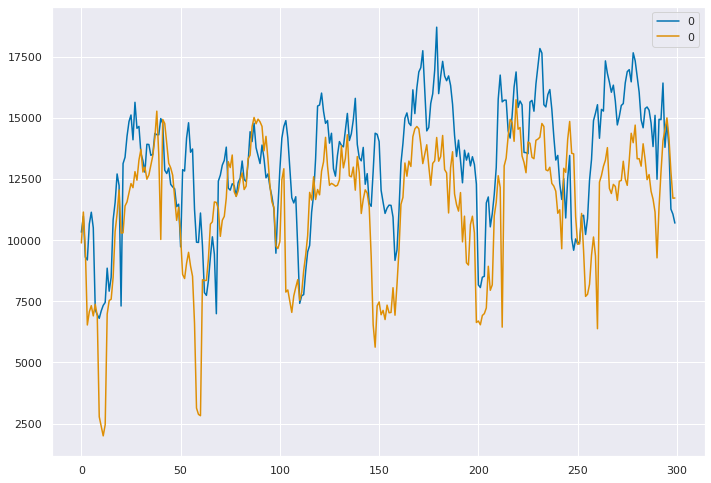

In [29]:
sns.lineplot(data=scaled_predictions[24:324,1:2], dashes=True, palette=colors[0:1])
sns.lineplot(data=data[0:300,1:2], linestyle='--',  palette=colors[1:2])